In [1]:
# import all necessary packages
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os
import tensorflow as tf

import keras
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K



Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)


2.0.8
1.3.0


In [3]:
# define the classes
Classes= ['airplane','angel','apple','baseball_bat','birthday_cake','bear','cello','dragon','elephant','flamingo','lipstick','map','moon','ocean','owl','passport','pig','police_car','rainbow','The_Mona_Lisa']
image_per_class = 50 #20 images per class
print('#Classes', len(Classes))
print('#Image per class', image_per_class)


#Classes 20
#Image per class 50


In [4]:
# This cell is only if you are loading the data from scratch
# generate data set
def generate_data_set(classes, start_from, num_examples_per_class):
    quickdraws = [np.load("./quickdraw/{}.npy".format(qdraw))[start_from:(start_from+num_examples_per_class)] for qdraw in classes]
    
    # Concat the arrays together
    x_data = np.concatenate(quickdraws,axis=0)
    x_data.shape
    
    filename = str(len(classes))+'class_'+str(num_examples_per_class)+'sample'+str(start_from)+'.npy'
    np.save('My_Data'+filename,x_data)

#Get the Data
generate_data_set(Classes, 20, image_per_class)
generate_data_set(Classes, 1000, image_per_class)

In [5]:
image_train_data = np.load("./My_Data20class_50sample1000.npy")
image_test_data = np.load("./My_Data20class_50sample20.npy")

print(image_train_data.shape)
print(image_test_data.shape)

(1000, 784)
(1000, 784)


In [6]:
## generate the labels for image
labels = [np.full((image_per_class,), Classes.index(qdraw)) for qdraw in Classes]
label_data = np.concatenate(labels,axis=0)
label_train_data = label_data
label_test_data = label_data

print(label_train_data.shape)
print(label_test_data.shape)
#label_data.shape



(1000,)
(1000,)


In [7]:
def show_object(obj):
    # Reshape 784 array into 28x28 image
    image = obj.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

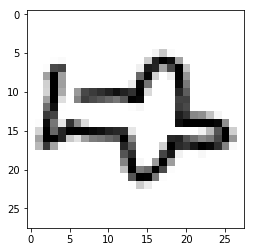

In [8]:
show_object(image_train_data[25])

# Shuffling function

In [9]:
#shuffling function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

image_train_data,label_train_data = unison_shuffled_copies(image_train_data,label_train_data)
image_test_data,label_test_data = unison_shuffled_copies(image_test_data,label_test_data)

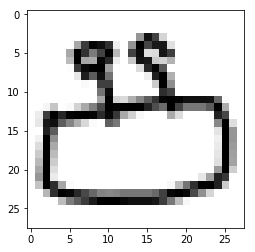

In [10]:
show_object(image_train_data[25])


# Generator

In [ ]:
def generator(features, labels, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 64, 64, 3))
    batch_labels = np.zeros((batch_size,1))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index= random.choice(len(features),1)
            batch_features[i] = some_processing(features[index])
            batch_labels[i] = labels[index]
        yield batch_features, batch_labels

# Prepare images for training in batches
batches = get_batches('./My_Data20class_50sample1000.npy', batch_size=batch_size)
val_batches = get_batches('./My_Data20class_50sample20.npy', batch_size=batch_size)

In [11]:
# define the training paramaters
batch_size = 100
num_classes = 20
epochs = 20

# Model 1

In [13]:
#Define the model1

input_shape = (1, 28, 28) #1 channel, 28x28 size

inputs = Input(input_shape) 
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', name = "Conv2d_1")(inputs)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', name = "Conv2d_2")(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name = "Maxpool2d_1")(x)
x = Flatten()(x)
x = Dense(128, activation='softmax', name = "Dense_1")(x)
x = Dense(128, activation='softmax', name = "Dense_2")(x)
outputs = Dense(len(Classes), activation='softmax', name = "Outputlayer")(x)

model = Model(inputs, outputs)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
Conv2d_1 (Conv2D)            (None, 1, 28, 32)         8096      
_________________________________________________________________
Conv2d_2 (Conv2D)            (None, 1, 28, 64)         18496     
_________________________________________________________________
Maxpool2d_1 (MaxPooling2D)   (None, 1, 14, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 896)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 128)               114816    
_________________________________________________________________
Dense_2 (Dense)              (None, 128)               16512     
__________

In [17]:
#compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#train the model
hist = model.fit_generator(batches,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=5,
          verbose=1,
          max_queue_size=10,
          validation_data=val_batches)


TypeError: get_batches() missing 1 required positional argument: 'self'

In [ ]:
metrics = model.evaluate_generator(val_batches,10,10,workers=1,pickle_safe=False)
print("model accuracy:",metrics[1])

In [ ]:
model.save('Quickdraw.hdf5')

# Model 2

In [17]:
#define the model2 - sequencial

input_shape = (1, 28, 28) #1 channel, 28x28 size

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])



ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_2/convolution' (op: 'Conv2D') with input shapes: [?,1,28,28], [3,3,28,32].

In [ ]:

img_rows = 28
img_cols = 28
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)



In [ ]:
#train the model
model.fit(image_train_data, labal_train_data,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(image_test_data, label_test_data))
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
#compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#train the model
model.fit(image_train_data, labal_train_data,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(image_test_data, label_test_data))
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
show_object(x_data[53000])
print(y_data[53000])